<a href="https://colab.research.google.com/github/K-osA/2022S-ML/blob/main/baseline_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge :: Cartoon Character Classification

만화 이미지를 보고 어떤 캐릭터인지를 분류하는 테스크입니다.  
캐릭터 클래스는 총 10개 입니다.

## Download Data
데이터 출처: https://www.kaggle.com/datasets/volkandl/cartoon-classification

코랩에서 캐글 데이터셋을 바로 불러오기 위해서 kaggle.json 파일이 필요합니다.  
```캐글 본인 계정 페이지``` -> ```Account``` -> ```API``` -> ```Create New API Token```
로 kaggle.json 파일을 다운로드 받을 수 있습니다.

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kosakosa","key":"5b6d04fc3fb2d4a3449a6fe2afb7f7a8"}'}

In [ ]:
ls -1ha kaggle.json # kaggle.json 확인

kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d volkandl/cartoon-classification

100% 11.5G/11.5G [03:03<00:00, 95.0MB/s]
100% 11.5G/11.5G [03:03<00:00, 67.5MB/s]


In [ ]:
!ls # 데이터셋 다운로드 확인

cartoon-classification.zip  kaggle.json  sample_data


In [ ]:
!unzip cartoon-classification.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5099.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY51.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY510.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5100.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5101.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5102.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5103.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5104.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5105.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5106.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5107.jpg  
  inflating: cartoon_classification/TRAIN/tom_and_jerry/TOM_AND_JERRY5108.jpg  
  infla

## Load Data

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import tensorflow
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.utils import to_categorical
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


In [ ]:
from PIL import ImageFile
from PIL import Image
ImageFile.LOAD_TRUNCATED_IMAGES = True # prevent truncate error

In [ ]:
from tensorflow.keras.utils import to_categorical, Sequence
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    shear_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    rotation_range=20,
    rescale=1./ 255,
    validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
        'cartoon_classification/TRAIN/',
        target_size=(400, 400),
        shuffle=True,
        class_mode='categorical',
        batch_size=16,
        subset='training')
valid_generator = train_datagen.flow_from_directory(
        'cartoon_classification/TRAIN/',
        target_size=(400, 400),
        shuffle=False,
        class_mode='categorical',
        batch_size=16,
        subset='validation')
test_datagen = ImageDataGenerator(rescale=1./ 255)
test_generator = test_datagen.flow_from_directory(
    'cartoon_classification/TEST/',
    shuffle=False,
    target_size=(400, 400),
    batch_size=16,
    class_mode='categorical'
)
print(train_generator.class_indices)
print(train_generator.classes)
print(valid_generator.class_indices)
print(valid_generator.classes)
print(test_generator.class_indices)
print(test_generator.classes)

Found 95697 images belonging to 10 classes.
Found 23920 images belonging to 10 classes.
Found 18110 images belonging to 10 classes.
{'Familyguy': 0, 'Gumball': 1, 'Tsubasa': 2, 'adventure_time': 3, 'catdog': 4, 'pokemon': 5, 'smurfs': 6, 'southpark': 7, 'spongebob': 8, 'tom_and_jerry': 9}
[0 0 0 ... 9 9 9]
{'Familyguy': 0, 'Gumball': 1, 'Tsubasa': 2, 'adventure_time': 3, 'catdog': 4, 'pokemon': 5, 'smurfs': 6, 'southpark': 7, 'spongebob': 8, 'tom_and_jerry': 9}
[0 0 0 ... 9 9 9]
{'Familyguy': 0, 'Gumball': 1, 'Tsubasa': 2, 'adventure_time': 3, 'catdog': 4, 'pokemon': 5, 'smurfs': 6, 'southpark': 7, 'spongebob': 8, 'tom_and_jerry': 9}
[0 0 0 ... 9 9 9]


## Show Example Data

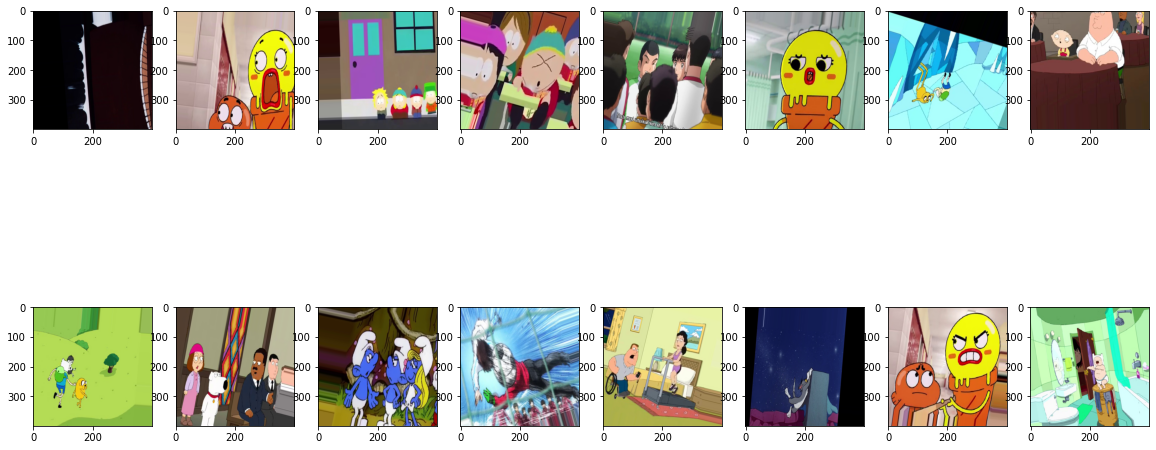

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x, y = train_generator.next()
fig, axs = plt.subplots(2, 8, figsize=(20, 10))
for i in range(8):
    axs[0, i].imshow(x[i])
    axs[1, i].imshow(x[i+8])
plt.show()


## Define a Convolutional Neural Network

Modified https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [ ]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 1, strides=strides, padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1, padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters * 4, 1, strides=1, padding="same", use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters * 4, 1, strides=strides, padding="same", use_bias=False),
                keras.layers.BatchNormalization()
            ]
        self.first_layers = [
            keras.layers.Conv2D(filters * 4, 1, strides=strides, padding="same", use_bias=False),
            keras.layers.BatchNormalization()
        ]
    def get_config(self):
      config = super().get_config().copy()
      config.update({
          'activation' : self.activation,
          'main_layers' : self.main_layers,
          'skip_layers' : self.skip_layers,
          'first_layers' : self.first_layers,
      })
      return config
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)

        if Z.shape[3] != skip_Z.shape[3]:
            for layer in self.first_layers:
                skip_Z = layer(skip_Z)

        return self.activation(Z + skip_Z)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[400, 400, 3], padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=5, strides=2, padding="same"))

# 50 -> 3, 4, 6, 3
# 101 -> 3, 4, 23, 3
# 152 -> 3, 8, 36, 3
prev_filters = 64
for filters in [64] * 3 + [128] * 8 + [256] * 36 + [512] * 3:
  strides = 1 if filters == prev_filters else 2
  model.add(ResidualUnit(filters, strides=strides))
  prev_filters = filters

model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

## Define a Loss function and optimizer

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
callbacks = [EarlyStopping(monitor='val_loss', patience=4, verbose=1),
             ModelCheckpoint(filepath='best_model.h5',
                             monitor='val_loss',
                             save_best_only=True)]
n_epoch = 20
batch_size = 16

## Train the Network

In [ ]:
print(train_generator.class_indices)
print(train_generator.classes)
print(valid_generator.class_indices)
print(valid_generator.classes)
print(test_generator.class_indices)
print(test_generator.classes)

{'Familyguy': 0, 'Gumball': 1, 'Tsubasa': 2, 'adventure_time': 3, 'catdog': 4, 'pokemon': 5, 'smurfs': 6, 'southpark': 7, 'spongebob': 8, 'tom_and_jerry': 9}
[0 0 0 ... 9 9 9]
{'Familyguy': 0, 'Gumball': 1, 'Tsubasa': 2, 'adventure_time': 3, 'catdog': 4, 'pokemon': 5, 'smurfs': 6, 'southpark': 7, 'spongebob': 8, 'tom_and_jerry': 9}
[0 0 0 ... 9 9 9]
{'Familyguy': 0, 'Gumball': 1, 'Tsubasa': 2, 'adventure_time': 3, 'catdog': 4, 'pokemon': 5, 'smurfs': 6, 'southpark': 7, 'spongebob': 8, 'tom_and_jerry': 9}
[0 0 0 ... 9 9 9]


In [ ]:
train_generator.reset()
valid_generator.reset()
history = model.fit(train_generator, epochs = n_epoch,
                    steps_per_epoch = 95697 // batch_size,
                    validation_steps = 23920 // batch_size,
                    validation_data=valid_generator, callbacks=[callbacks])
#history = model.fit(X_train, y_train, epochs = n_epoch, batch_size=batch_size,
                    #validation_data=(X_valid, y_valid), callbacks=[callbacks])
print("Finished Training")

Epoch 1/20
5981/5981 [==============================] - 4317s 718ms/step - loss: 0.5411 - accuracy: 0.8196 - val_loss: 2.9775 - val_accuracy: 0.7046
Epoch 2/20
5981/5981 [==============================] - 4370s 731ms/step - loss: 0.1289 - accuracy: 0.9597 - val_loss: 7.8551 - val_accuracy: 0.6783
Epoch 3/20
5981/5981 [==============================] - 4366s 730ms/step - loss: 0.0740 - accuracy: 0.9767 - val_loss: 3.0011 - val_accuracy: 0.5151
Epoch 4/20
5981/5981 [==============================] - 4310s 720ms/step - loss: 0.0505 - accuracy: 0.9845 - val_loss: 0.7856 - val_accuracy: 0.8495
Epoch 5/20
5981/5981 [==============================] - 4315s 721ms/step - loss: 0.0385 - accuracy: 0.9881 - val_loss: 0.3839 - val_accuracy: 0.9059
Epoch 6/20
5981/5981 [==============================] - 4300s 719ms/step - loss: 0.0332 - accuracy: 0.9901 - val_loss: 34.9697 - val_accuracy: 0.2398
Epoch 7/20
5981/5981 [==============================] - 4297s 718ms/step - loss: 0.0256 - accuracy: 0.992

## Save the Network

In [ ]:
# save the trained model
# PATH = './net.pth'
# torch.save(net.state_dict(), PATH)

## Load the Network

In [ ]:
model.load_weights('best_model.h5')

In [ ]:
model.save('best_model_whole.h5')

## Testing & Making a Submission File

In [ ]:
test_generator.reset()
result = model.evaluate(test_generator)
print(result)

test_generator.reset()
output = model.predict(test_generator)
output = np.argmax(output, axis=-1)

print(output)

1132/1132 [==============================] - 272s 240ms/step - loss: 0.6172 - accuracy: 0.9009
[0.6172086000442505, 0.9009386897087097]
[0 0 0 ... 9 9 9]


In [ ]:
test_file_path = []
cartoon_list = ["Familyguy", "Gumball", "Tsubasa", "adventure_time", "catdog", "pokemon", "smurfs", "southpark",
                "spongebob", "tom_and_jerry"]
for cartoon in cartoon_list:
  for file in tqdm(os.listdir('./cartoon_classification/TEST/' + cartoon)):
    test_file_path.append(cartoon + '/' + file)

  0%|          | 0/1788 [00:00<?, ?it/s]

  0%|          | 0/2077 [00:00<?, ?it/s]

  0%|          | 0/1305 [00:00<?, ?it/s]

  0%|          | 0/1756 [00:00<?, ?it/s]

  0%|          | 0/2179 [00:00<?, ?it/s]

  0%|          | 0/1608 [00:00<?, ?it/s]

  0%|          | 0/1909 [00:00<?, ?it/s]

  0%|          | 0/1363 [00:00<?, ?it/s]

  0%|          | 0/1957 [00:00<?, ?it/s]

  0%|          | 0/2168 [00:00<?, ?it/s]

In [ ]:
submit_sol = pd.DataFrame(list(zip(test_file_path, output)), columns=['id','predicted'])

In [ ]:
submit_sol

,id,predicted
0,Familyguy/family_guy349.jpg,0
1,Familyguy/family_guy114.jpg,0
2,Familyguy/family_guy11556.jpg,0
3,Familyguy/family_guy11051.jpg,0
4,Familyguy/family_guy12669.jpg,0
...,...,...
18105,tom_and_jerry/TOM_AND_JERRY26346.jpg,9
18106,tom_and_jerry/TOM_AND_JERRY25216.jpg,9
18107,tom_and_jerry/TOM_AND_JERRY11592.jpg,9
18108,tom_and_jerry/TOM_AND_JERRY11733.jpg,9


In [ ]:
import os

def clean_path(path):
  cleaned_path = os.path.normpath(path)
  cleaned_path = path.split(os.sep)
  new_path = cleaned_path[3] +'/' + cleaned_path[4] # cartoon name/xx.jpg
  return new_path

In [ ]:
submit_sol.to_csv('test_result.csv', index=False)  # submit this test_result.csv to kaggle server

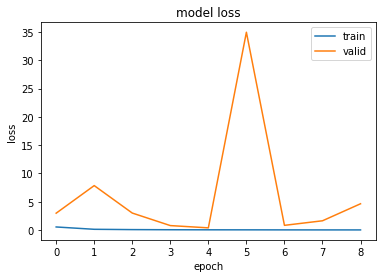

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='best')
plt.savefig('model_loss.png')
plt.show()

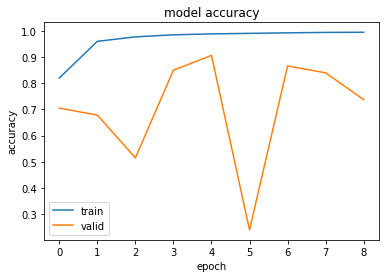

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='best')
plt.savefig('model_accuracy.png')
plt.show()